# LE Shifts and Lags using covariates and model averaging (stacking)

## Some definitions

- Define set of priors (for reproducibility)
     - I am using `prior = set_prior("normal(0, 5)", class = "b")` for all betas.
     - 2000 iterations and 2 chains
- Set seed: 850091718

## Nomenclature

- m1 = LE 1900 models
- m2 = LE 1950 models
- m3 = Cause of death 1900 models
- m4 = Cause of death 1950 models

In [1]:
library(here)
library(haven)
library(sdazar)
library(data.table)
library(ggplot2)
library(stringr)
library(brms)
options(mc.cores = parallel::detectCores()-2)
library(imputeTS)
# library(stringr)
# library(ggridges)
# library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
library(texreg)
seed = 850091718

here() starts at /Users/sebastiandaza/Documents/papers/lambda
Loading required package: data.table
Loading required package: knitr
Loading required package: miceadds
Loading required package: mice
Loading required package: lattice
* miceadds 2.10-14 (2018-03-29 14:47:31)
Loading required package: Rcpp
Loading 'brms' package (version 2.5.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:sdazar’:

    mi

Version:  1.36.23
Date:     2017-03-03
Author:   Philip Leifeld (University of Glasgow)

Please cite the JSS article in your publications -- see citation("texreg").


In [2]:
# functions 

source('functions.R')

# estimate_shift

In [3]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador", 
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

# Only male-female average and records since 1900

In [4]:
# covariates = names(df)[10:28]
# print(covariates)
covariates = c("gdp_pc", "urban", "elec", "lit" ,"water" ,"sewage" ,"gini" ,
               "tfr" ,"bf" ,"extFund" ,"healthGdp" ,"lsi" ,"polio" ,"bcg" ,"dpt1" ,"dpt3" ,"mcv1" ,
               "us_aid" ,"lunion")
# life expectancy 0, tseries == 2 

c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max), 
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

# check
# (nrow(c) + nrow(le))/2

dt = merge(c, le, by=c('ctry', 'year'))

# missing data
print(countmis(dt))

       bf      elec       lsi       lit   extFund      gini     water    sewage 
    0.977     0.951     0.922     0.852     0.844     0.820     0.775     0.773 
healthGdp     polio       bcg      dpt1      dpt3      mcv1     urban       tfr 
    0.709     0.681     0.681     0.681     0.681     0.681     0.451     0.445 
   us_aid    gdp_pc 
    0.360     0.103 


### Define dataset

In [5]:
test = dt[year>=1900, .(ctry, year, gdp_pc, urban, lit, Ex, water, sewage, elec, us_aid, tfr)]

In [6]:
# year recode based on the criteria proposed by Alberto
test[year<1950, gyear:='1950']
test[year>=1950 & year<1970, gyear:='1950-1969']
test[year>=1970 & year<1990, gyear:='1970-1989']
test[year>=1990, gyear :='1990']
# # test[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

# transform variable: weibull
test[, y := Ex/max(Ex+1.05), by = ctry] # adjustment is by country!
test[, wy := log(-log(1-y))]
test[, max_le := max(Ex+1.05), by = ctry] # to recover values later
test[, ctry_year := paste0(ctry,'.', gyear)]

In [7]:
head(test)

ctry,year,gdp_pc,urban,lit,Ex,water,sewage,elec,us_aid,tfr,gyear,y,wy,max_le,ctry_year
Argentina,1900,2875.352,NA,51,36.25867,NA,NA,NA,NA,NA,1950,0.4762391,-0.4358419,76.13545,Argentina.1950
Argentina,1901,2880.387,NA,NA,36.63120,NA,NA,NA,NA,NA,1950,0.4811320,-0.4214333,76.13545,Argentina.1950
Argentina,1902,2716.507,NA,NA,37.00985,NA,NA,NA,NA,NA,1950,0.4861054,-0.4068604,76.13545,Argentina.1950
Argentina,1903,2992.315,NA,NA,37.39479,NA,NA,NA,NA,NA,1950,0.4911614,-0.3921179,76.13545,Argentina.1950
Argentina,1904,3191.040,NA,NA,37.82295,NA,NA,NA,NA,NA,1950,0.4967851,-0.3758025,76.13545,Argentina.1950
Argentina,1905,3478.617,NA,NA,38.48985,NA,NA,NA,NA,NA,1950,0.5055445,-0.3505536,76.13545,Argentina.1950


In [8]:
# number of countries
length(unique(test$ctry))

[1] 19

# 1900+ model using imputed gdp, lit, urban variables (interpolation)

In [9]:
library(imputeTS)

test = data.table(test)
setorder(test, year)

# interpolation
test[, igdp_pc := na.interpolation(gdp_pc, option='stine'), by=ctry]
test[, iurban := na.interpolation(urban, option='stine'), by=ctry]
test[, ilit := na.interpolation(lit, option='stine'), by=ctry]
test[, itfr := na.interpolation(tfr, option='stine'), by=ctry]

test[, iwater := na.interpolation(water, option='stine'), by=ctry]
test[, isewage := na.interpolation(sewage, option='stine'), by=ctry]
test[, ielec := na.interpolation(elec, option='stine'), by=ctry]

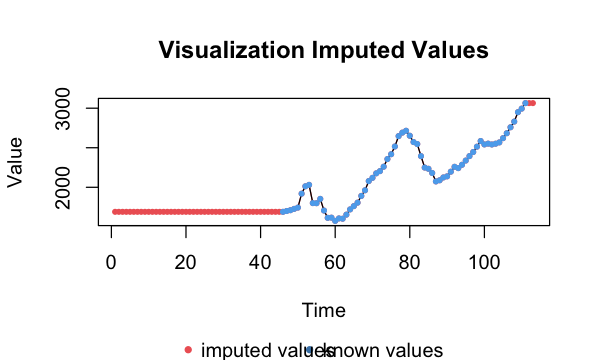

In [10]:
country = 'Bolivia'
variable = 'gdp_pc'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

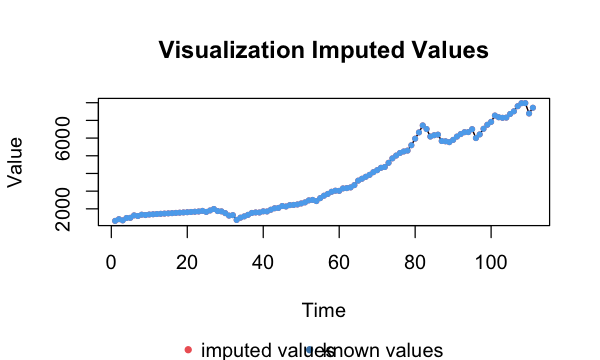

In [11]:
country = 'Mexico'
variable = 'gdp_pc'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

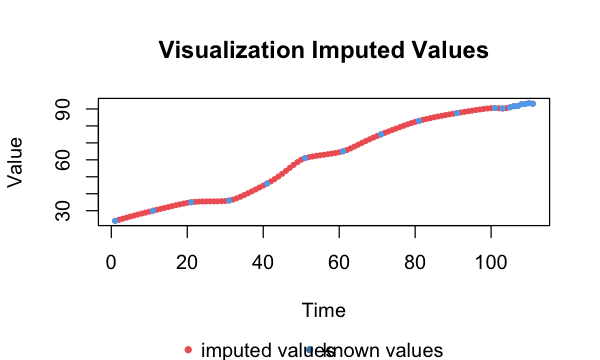

In [12]:
country = 'Mexico'
variable = 'lit'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

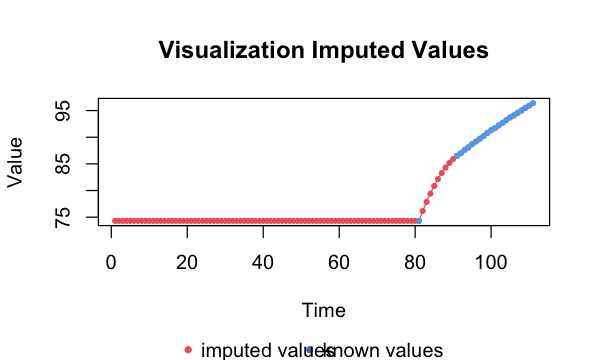

In [13]:
country = 'Argentina'
variable = 'sewage'
imp = paste0('i', variable)

plotNA.imputations(test[ctry==country, variable, with=FALSE][[1]], 
                   test[ctry==country, imp, with=FALSE][[1]])

## Bayesian models using the interpolation method

- Variables are centered to improve convergence

In [14]:
test[, igdp_log := scale(log(igdp_pc), scale=FALSE, center=TRUE)]
test[, iurban_log := scale(log(iurban), scale=FALSE, center=TRUE)]
test[, ilit_log := scale(log(ilit), scale=FALSE, center=TRUE)]
test[, iwater_log := scale(log(iwater), scale=FALSE, center=TRUE)]
test[, isewage_log := scale(log(isewage), scale=FALSE, center=TRUE)]
test[, ielec_log := scale(log(isewage), scale=FALSE, center=TRUE)]

In [15]:
# lag variables and fitering
setorder(test, ctry, year)

In [16]:
# test[, lag_igdp_log := shift(igdp_log), by=ctry]
# test[, lag_iurban_log := shift(iurban_log), by=ctry]
# test[, lag_ilit_log := shift(ilit_log), by=ctry]
test[, zyear := scale(year, center=TRUE, scale=TRUE)]

# Models 

Important notes: 

- Random intercept by country and year
- Random GDP coefficient by country and year
- All the other covariates are fixed (unique coefficient or beta)
- No interactions between variables

# 1900

## GDP only with different time adjustments

In [18]:
# set prior of betas to normal(0,5)
prior = set_prior("normal(0, 5)", class = "b")

In [19]:
m1.1 = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

Compiling the C++ model


In [43]:
loo1.1 = loo(m1.1, reloo=TRUE)

3 problematic observation(s) found.
The model will be refit 3 times.

Fitting model 1 out of 3 (leaving out observation 295)
Start sampling

Fitting model 2 out of 3 (leaving out observation 1420)
Start sampling

Fitting model 3 out of 3 (leaving out observation 1632)
Start sampling


In [147]:
est_shifts = compute_shifts(models = list(m1.1),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [149]:
dim(est_shifts)

[1] 562000      9

In [65]:
fwrite(est_shifts, 'output/shift_1900_gdponly.csv')

In [130]:
m1.1.year = brm(formula = wy ~ 1 + igdp_log + zyear + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [131]:
summary(m1.1.year)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + zyear + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.29      0.03     0.24     0.34        289 1.00
sd(igdp_log)                0.46      0.04     0.38     0.55        517 1.01
cor(Intercept,igdp_log)     0.17      0.12    -0.09     0.41        240 1.01

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.23      0.04     0.16     0.30        152 1.00
igdp_log      0.31      0.06     0.19     0.42        362 1.01
zyear         0.41      0.01     0.39     0.42       2000 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.

In [132]:
loo1.1.year = loo(m1.1.year, reloo=TRUE)

1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1420)
Start sampling


In [168]:
est_shifts_year = compute_shifts(models = list(m1.1.year),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [70]:
fwrite(est_shifts_year, 'output/shift_1900_gdponly_year.csv')

In [21]:
m1.1.auto = brm(formula = wy ~ 1 + igdp_log + (igdp_log|ctry_year), 
           autocor = cor_ar(~wy|ctry, p = 1),
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed)

Compiling the C++ model
Start sampling


In [167]:
summary(m1.1.auto)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Correlation Structures:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
ar[1]     1.00      0.00     1.00     1.00       2000 1.00

Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.14      0.02     0.10     0.19        359 1.01
sd(igdp_log)                0.06      0.03     0.00     0.11        336 1.00
cor(Intercept,igdp_log)    -0.64      0.34    -0.99     0.35        469 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.40      0.03    -0.45    -0.35        742 1.00
igdp_log      0.08      0.02     0.04     0.12        778 1.00

Fami

In [169]:
est_shifts_out = compute_shifts(models = list(m1.1.auto),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [170]:
fwrite(est_shifts_out, 'output/shift_1900_gdponly_autocorrelation.csv')

# LE stacking models, 1900+, no time adjustment

In [171]:
m1.2 = brm(formula = wy ~ 1 + igdp_log  + iurban_log +  (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

loo1.2 = loo(m1.2, reloo=TRUE)

Compiling the C++ model
Start sampling


In [44]:
m1.3 = brm(formula = wy ~ 1 + igdp_log  + ilit_log +  (igdp_log|ctry_year), 
          data = test,
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

loo1.3 = loo(m1.3, reloo=TRUE)

In [44]:
m1.4 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

loo1.4 = loo(m1.4, reloo=TRUE)

In [137]:
# stacking
loo_list_noyear = list(loo1.1, loo1.2, loo1.3, loo1.4)
weights_models_noyear = as.vector(loo_model_weights(loo_list_noyear))
weights_models_noyear

[1] 1.410794e-02 3.356404e-07 1.436968e-02 9.715220e-01

In [19]:
# # export posterior values 
# s = posterior_samples(m1.1)
# fwrite(s, 'output/posterior_samples_gdp_only.csv')-

In [138]:
models_noyear = list(m1.1, m1.2, m1.3, m1.4)
ps_noyear = list(posterior_samples(m1.1), posterior_samples(m1.2), posterior_samples(m1.3), 
                        posterior_samples(m1.4))

In [139]:
test_shift_noyear = estimate_shift(models = models_noyear,
                        ps = ps_noyear,
                        weights = weights_models_noyear,
                        data = test, 
                        country = 'Venezuela', 
                        cfyear = 2010, 
                        segment = '1990')

In [145]:
est_shifts_noyear = compute_shifts(models = models_noyear,
                        ps = ps_noyear,
                        weights = weights_models_noyear,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [150]:
dim(est_shifts_noyear)

[1] 562000      9

In [142]:
# save file
fwrite(est_shifts_noyear, 'output/shift_1900_stacking.csv')

# LE stacking models, 1900+, linear adjustment of time

In [151]:
m1.2.year = brm(formula = wy ~ 1 + igdp_log  + iurban_log + zyear + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

loo1.2.year = loo(m1.2.year, reloo=TRUE)

In [151]:
m1.3.year = brm(formula = wy ~ 1 + igdp_log  + ilit_log + zyear +  (igdp_log|ctry_year), 
          data = test,
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

loo1.3.year = loo(m1.3.year, reloo=TRUE)

In [151]:
m1.4.year = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + zyear + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior)

loo1.4.year = loo(m1.4.year, reloo=TRUE)

In [163]:
# stacking
models_year = list(m1.1.year, m1.2.year, m1.3.year, m1.4.year)
ps_year = list(posterior_samples(m1.1.year), posterior_samples(m1.2.year), posterior_samples(m1.3), 
                        posterior_samples(m1.4))

loo_list_year = list(loo1.1.year, loo1.2.year, loo1.3.year, loo1.4.year)
weights_models_year = as.vector(loo_model_weights(loo_list_year))

In [155]:
test_shift_year = estimate_shift(models = models_year,
                        ps = ps_year,
                        weights = weights_models_year,
                        data = test, 
                        country = 'Venezuela', 
                        cfyear = 2010, 
                        segment = '1990')

In [156]:
head(test_shift_year)

id,obs_ex,pred_ex,counterfactual,shift_obs,shift_pred
1,72.90567,72.29739,72.29739,0.6082808,0
2,72.90567,72.28007,72.28007,0.6255954,0
3,72.90567,72.16741,72.16741,0.7382591,0
4,72.90567,72.23831,72.23831,0.6673576,0
5,72.90567,72.33673,72.33673,0.5689393,0
6,72.90567,72.28488,72.28488,0.6207858,0


In [158]:
est_shifts_year = compute_shifts(models = models_year,
                        ps = ps_year,
                        weights = weights_models_year,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [160]:
head(est_shifts_year)

ctry,year,segment,num_models,obs_ex,pred_ex,counterfactual,shift_obs,shift_pred
Argentina,1950,1950,4,61.75226,62.70597,58.72030,3.031952,3.985666
Argentina,1950,1950,4,61.75226,62.49086,59.03357,2.718688,3.457289
Argentina,1950,1950,4,61.75226,62.90609,58.06169,3.690571,4.844404
Argentina,1950,1950,4,61.75226,62.97750,58.51666,3.235597,4.460837
Argentina,1950,1950,4,61.75226,62.52959,59.04609,2.706166,3.483500
Argentina,1950,1950,4,61.75226,62.50109,58.56104,3.191214,3.940048


In [161]:
dim(est_shifts_year)

[1] 562000      9

In [159]:
# save file
fwrite(est_shifts_year, 'output/shift_1900_stacking_year.csv')

# LE individual models, 1900+, autocorrelation adjustment

- These models take so long to run, specially the LOO estimates, so not stacking for these models, just individual outputs. 
- Only gdp only and full model. 

In [26]:
m1.4.auto = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
          autocor = cor_ar(~wy|ctry, p = 1),      
          data = test, 
          iter = 2000, 
          chains = 2, 
          seed = seed, 
          prior = prior,
          control=  list(adapt_delta=0.90))

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [27]:
est_shifts_out = compute_shifts(models = list(m1.4.auto),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [28]:
fwrite(est_shifts_out, 'output/shift_1900_full_autocorrelation.csv')

# 1950 >

- Important: imputation of electricy, sewage and water is via interpolation

In [17]:
test2 = test[year>=1950]

## GDP only with different time adjustments

In [20]:
# set prior of betas to normal(0,5)
prior = set_prior("normal(0, 5)", class = "b")

In [47]:
test_shifts = compute_shifts(models = list(m2.1),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [48]:
dim(est_shifts)

[1] 562000      9

In [49]:
fwrite(est_shifts, 'output/shift_1950_gdponly.csv')

In [130]:
m2.1.year = brm(formula = wy ~ 1 + igdp_log + zyear + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [131]:
summary(m1.1.year)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + zyear + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.29      0.03     0.24     0.34        289 1.00
sd(igdp_log)                0.46      0.04     0.38     0.55        517 1.01
cor(Intercept,igdp_log)     0.17      0.12    -0.09     0.41        240 1.01

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.23      0.04     0.16     0.30        152 1.00
igdp_log      0.31      0.06     0.19     0.42        362 1.01
zyear         0.41      0.01     0.39     0.42       2000 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.

In [132]:
loo1.1.year = loo(m1.1.year, reloo=TRUE)

1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1420)
Start sampling


In [168]:
est_shifts_year = compute_shifts(models = list(m1.1.year),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010))

In [70]:
fwrite(est_shifts_year, 'output/shift_1900_gdponly_year.csv')

In [18]:
names(test2)

[1] "ctry"        "year"        "gdp_pc"      "urban"       "lit"        
 [6] "Ex"          "water"       "sewage"      "elec"        "us_aid"     
[11] "tfr"         "gyear"       "y"           "wy"          "max_le"     
[16] "ctry_year"   "igdp_pc"     "iurban"      "ilit"        "itfr"       
[21] "iwater"      "isewage"     "ielec"       "igdp_log"    "iurban_log" 
[26] "ilit_log"    "iwater_log"  "isewage_log" "ielec_log"   "zyear"

In [ ]:
- gdp
- gdp + iwater_log + isewage_log + ielec_log
- gdp + ilit_log + iurban_log
- gdp + ilit_log + iurban_log + iwater_log + isewage_log + ielec_log

In [21]:
m2.1 = brm(formula = wy ~ 1 + igdp_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

Compiling the C++ model
Start sampling


In [ ]:
m2.2 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

Compiling the C++ model
recompiling to avoid crashing R session
Start sampling


In [ ]:
m2.3 = brm(formula = wy ~ 1 + igdp_log + iwater_log + isewage_log + ielec_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [ ]:
m2.4 = brm(formula = wy ~ 1 + igdp_log + ilit_log + iurban_log + iwater_log + isewage_log + ielec_log + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2,
           seed = seed, 
           prior=prior)

In [22]:
loo2.1 = loo(m2.1, reloo=TRUE)
loo2.2 = loo(m2.2, reloo=TRUE)
loo2.3 = loo(m2.3, reloo=TRUE)
loo2.4 = loo(m2.4, reloo=TRUE)

1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 631)
Start sampling


# Old models
# Lags

In [74]:
models_1 = list(m1.1, m1.2, m1.3, m1.4)
ps_1 = list(posterior_samples(m1.1), posterior_samples(m1.2), posterior_samples(m1.3), 
                       posterior_samples(m1.4))

test_lags = estimate_lag(models = models_1,
                        ps = ps_1,
                        weights = weights_models_1,
                        data = test, 
                        country = 'Argentina', 
                        cfyear = 1990, 
                        segment = '1950',
                        predicted_values = FALSE)

In [86]:
est_lags_obs = compute_lags(models = models_1,
                        ps = ps_1,
                        weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = FALSE)

In [90]:
est_lags_pred = compute_lags(models = models_1,
                        ps = ps_1,
                        weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = TRUE)

In [91]:
fwrite(est_lags_obs, 'output/lags_obs.csv')
fwrite(est_lags_pred, 'output/lags_pred.csv')

# Adjusting by time

- Same as `m1`, but adding `zyear` (standardized year variable)
- The only coefficient is changing by country and year is `gdp_log`
- How to interpret this results


In [17]:
m2.1 = brm(formula = wy ~ 1 + zyear + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2)

loo2.1 = loo(m2.1, reloo=TRUE)

m2.2 = brm(formula = wy ~ 1 +  zyear + igdp_log  + iurban_log +  (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2)

loo2.2 = loo(m2.2, reloo=TRUE)

m2.3 = brm(formula = wy ~ 1 +  zyear + igdp_log  + ilit_log +  (igdp_log|ctry_year), 
          data = test,
          iter = 2000, 
          chains = 2)

loo2.3 = loo(m2.3, reloo=TRUE)

m2.4 = brm(formula = wy ~ 1 + zyear + igdp_log + ilit_log + iurban_log + (igdp_log|ctry_year), 
          data = test, 
          iter = 2000, 
          chains = 2)

loo2.4 = loo(m2.4, reloo=TRUE)

# stacking
loo_list_2 = list(loo2.1, loo2.2, loo2.3, loo2.4)
weights_models_2 = as.vector(loo_model_weights(loo_list_2))
print(weights_models_2)

Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1418)
Start sampling
Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1418)
Start sampling
Compiling the C++ model
Start sampling
1 problematic observation(s) found.
The model will be refit 1 times.

Fitting model 1 out of 1 (leaving out observation 1418)
Start sampling
Compiling the C++ model
Start sampling
2 problematic observation(s) found.
The model will be refit 2 times.

Fitting model 1 out of 2 (leaving out observation 1418)
Start sampling

Fitting model 2 out of 2 (leaving out observation 1420)
Start sampling


[1] 1.250149e-05 1.307681e-01 3.037624e-01 5.654570e-01


In [193]:
models_2 = list(m2.1, m2.2, m2.3, m2.4)

ps_2 = list(posterior_samples(m2.1), posterior_samples(m2.2), posterior_samples(m2.3), 
                       posterior_samples(m2.4))

In [194]:
est_shifts_obs_time = compute_shifts(models = models_2,
                        ps = ps_2,
                        weights = weights_models_2,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = FALSE)

In [195]:
est_shifts_pred_time = compute_shifts(models = list(m2.1),
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = TRUE)

In [197]:
fwrite(est_shifts_obs_time, 'output/shifts_obs_time.csv')
fwrite(est_shifts_pred_time, 'output/shifts_pred_time.csv')

# Adjusting by time and gdp

- Same as `m1`, but adding `zyear`  (standardized year variable)
- The only coefficient is changing by country and year is `gdp_log`

In [38]:
est_shifts_obs = compute_shifts(models = list(m2.1),
#                         ps = ps_1,
#                         weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = FALSE)

In [36]:
est_shifts_pred = compute_shifts(models = list(m2.1),
#                         ps = ps_1,
#                         weights = weights_models_1,
                        data = test, 
                        countries = country_labels, 
                        years = c(1950, 1970, 1990, 2010),
                        predicted_values = TRUE)

In [39]:
fwrite(est_shifts_obs, 'output/shifts_obs_gdp_time.csv')
fwrite(est_shifts_pred, 'output/shifts_pred_gdp_time.csv')

In [40]:
summary(m2.1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + zyear + igdp_log + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.29      0.03     0.24     0.35        368 1.00
sd(igdp_log)                0.46      0.04     0.38     0.55        529 1.00
cor(Intercept,igdp_log)     0.15      0.13    -0.11     0.38        421 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.24      0.03     0.17     0.30        229 1.03
zyear         0.41      0.01     0.39     0.42       2000 1.00
igdp_log      0.31      0.06     0.20     0.41        426 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.

# Checks

## Notes

- igdp_log is the log of the imputed gdp_pc, after computing that variable I centered it (global average = 0)
- wy is the transformation of Ex (see code above), not centered

In [184]:
summary(test[, .(wy, igdp_log)])

       wy             igdp_log       
 Min.   :-0.7899   Min.   :-1.41014  
 1st Qu.:-0.2889   1st Qu.:-0.46569  
 Median : 0.2831   Median :-0.07965  
 Mean   : 0.2879   Mean   : 0.00000  
 3rd Qu.: 0.8279   3rd Qu.: 0.43028  
 Max.   : 1.4663   Max.   : 1.62753  

In [185]:
m1.1 = brm(formula = wy ~ 1 + igdp_log  + (igdp_log|ctry_year), 
           data = test,
           iter = 2000, 
           chains = 2)

Compiling the C++ model
Start sampling


In [186]:
s = data.table(posterior_samples(m1.1))

In [187]:
summary(m1.1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log + (igdp_log | ctry_year) 
   Data: test (Number of observations: 1848) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 2000

Group-Level Effects: 
~ctry_year (Number of levels: 74) 
                        Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)               0.53      0.05     0.45     0.63        316 1.01
sd(igdp_log)                0.67      0.07     0.55     0.81        618 1.00
cor(Intercept,igdp_log)     0.06      0.14    -0.21     0.33        257 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.34      0.06     0.22     0.47        220 1.01
igdp_log      0.76      0.09     0.58     0.94        258 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.11      0.00     0.10     0.11       2000 1.00


In [188]:
ss = s[, lapply(.SD, median)] # compute median to estimate CF

# Mexico 1950 using segment 1990

In [124]:
coeffs = t(ss[, .SD, .SDcols = names(ss) %like% '^b|Mexico'])

In [125]:
coeffs

b_Intercept,0.33976808
b_igdp_log,0.76234434
"r_ctry_year[Mexico.1950,Intercept]",-0.49488461
"r_ctry_year[Mexico.1950-1969,Intercept]",-0.23651877
"r_ctry_year[Mexico.1970-1989,Intercept]",-0.26937527
"r_ctry_year[Mexico.1990,Intercept]",-0.57328045
"r_ctry_year[Mexico.1950,igdp_log]",0.15374043
"r_ctry_year[Mexico.1950-1969,igdp_log]",0.06364853
"r_ctry_year[Mexico.1970-1989,igdp_log]",0.08240534
"r_ctry_year[Mexico.1990,igdp_log]",0.75668082


In [144]:
test[ctry=='Mexico' & year==1990, igdp_log]

[1] 0.8026646
attr(,"scaled:center")
[1] 7.910903

In [159]:
(log_gpd_mexico_1950 = test[ctry=='Mexico' & year==1950, igdp_log])
(max_value = test[ctry=='Mexico' & year==1950, max_le])

[1] -0.1423613
attr(,"scaled:center")
[1] 7.910903

[1] 75.74707

In [127]:
(cf = coeffs[1] + coeffs[6] + log_gpd_mexico_1950 * (coeffs[2] + coeffs[10]))

[1] -0.4497628
attr(,"scaled:center")
[1] 7.910903

In [128]:
# counterfactual
(acf = get_orig_values_weibull(cf, max_value))

[1] 35.71742
attr(,"scaled:center")
[1] 7.910903

In [160]:
get_orig_values_weibull(test[ctry=='Mexico' & year==1950, wy], max_value)

[1] 46.40561

In [129]:
# observed
(obs = test[ctry=='Mexico' & year==1950, Ex])

[1] 46.40561

In [130]:
obs - acf

[1] 10.68818
attr(,"scaled:center")
[1] 7.910903

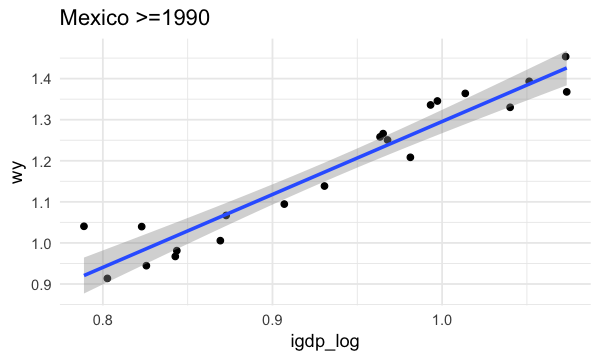

In [150]:
ggplot(test[ctry=='Mexico' & year>= 1990], aes(igdp_log, wy)) + geom_point() + geom_smooth(method='lm') + theme_minimal() + 
    labs(title='Mexico >=1990')

In [132]:
print(screenreg(lm(wy ~ igdp_log, data = test[ctry=='Mexico' & year>= 1990])))


             Model 1  
----------------------
(Intercept)  -0.48 ***
             (0.11)   
igdp_log      1.78 ***
             (0.12)   
----------------------
R^2           0.92    
Adj. R^2      0.91    
Num. obs.    21       
RMSE          0.05    
*** p < 0.001, ** p < 0.01, * p < 0.05


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


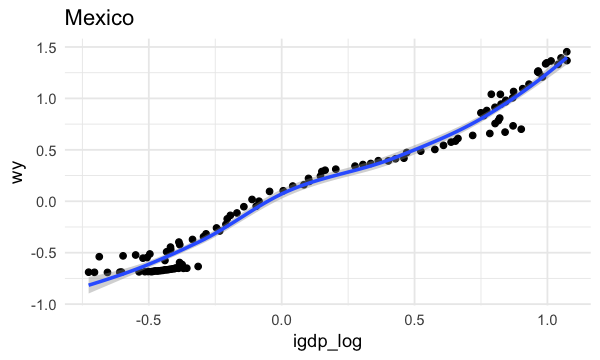

In [183]:
ggplot(test[ctry=='Mexico'], aes(igdp_log, wy)) + geom_point() + geom_smooth() + theme_minimal() + 
    labs(title='Mexico')

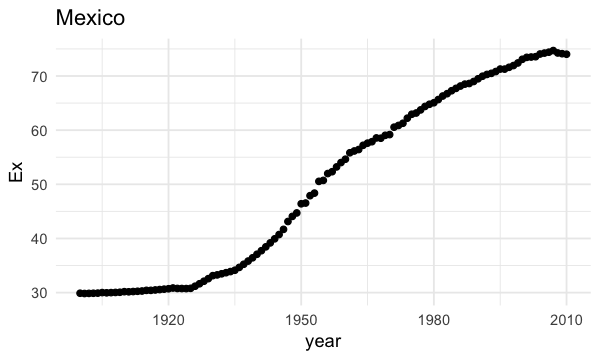

In [178]:
ggplot(test[ctry=='Mexico'], aes(year, Ex)) + geom_point()  + theme_minimal() + 
    labs(title='Mexico')

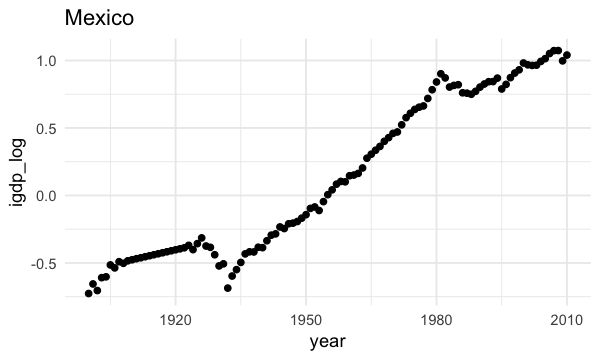

In [179]:
ggplot(test[ctry=='Mexico'], aes(year, igdp_log)) + geom_point()  + theme_minimal() + 
    labs(title='Mexico')

# Argentina 1950 using segment 1990

In [133]:
coeffs = t(ss[, .SD, .SDcols = names(ss) %like% '^b|Argentina'])

In [151]:
coeffs

b_Intercept,0.33976808
b_igdp_log,0.76234434
"r_ctry_year[Argentina.1950,Intercept]",-0.73344789
"r_ctry_year[Argentina.1950-1969,Intercept]",-0.08791148
"r_ctry_year[Argentina.1970-1989,Intercept]",0.70430181
"r_ctry_year[Argentina.1990,Intercept]",-0.07829758
"r_ctry_year[Argentina.1950,igdp_log]",0.48462614
"r_ctry_year[Argentina.1950-1969,igdp_log]",-0.23644627
"r_ctry_year[Argentina.1970-1989,igdp_log]",-0.94058347
"r_ctry_year[Argentina.1990,igdp_log]",0.09051524


In [143]:
test[ctry=='Argentina' & year==1990, igdp_log]

[1] 0.8582814
attr(,"scaled:center")
[1] 7.910903

In [135]:
(log_gpd_argentina_1950 = test[ctry=='Argentina' & year==1950, igdp_log])
(max_value = test[ctry=='Argentina' & year==1950, max_le])

[1] 0.6036318
attr(,"scaled:center")
[1] 7.910903

[1] 76.13545

In [136]:
(cf = coeffs[1] + coeffs[6] + log_gpd_argentina_1950 * (coeffs[2] + coeffs[10]))

[1] 0.7762837
attr(,"scaled:center")
[1] 7.910903

In [137]:
# counterfactual
(acf = get_orig_values_weibull(cf, max_value))

[1] 67.47182
attr(,"scaled:center")
[1] 7.910903

In [138]:
# observed
(obs = test[ctry=='Mexico' & year==1950, Ex])

[1] 46.40561

In [139]:
obs - acf

[1] -21.06621
attr(,"scaled:center")
[1] 7.910903

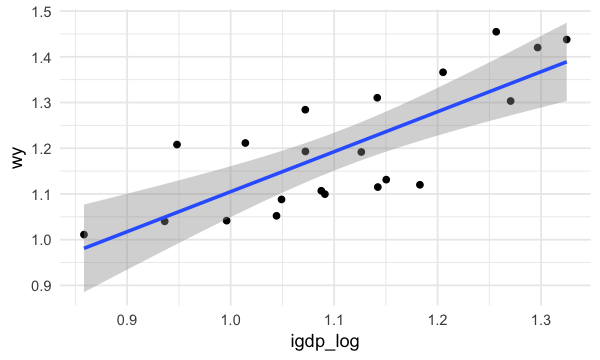

In [152]:
ggplot(test[ctry=='Argentina' & year>= 1990], aes(igdp_log, wy)) + geom_point() + geom_smooth(method='lm') + theme_minimal()

In [141]:
print(screenreg(lm(wy ~ igdp_log, data = test[ctry=='Argentina' & year>= 1990])))


             Model 1  
----------------------
(Intercept)   0.23    
             (0.18)   
igdp_log      0.87 ***
             (0.17)   
----------------------
R^2           0.60    
Adj. R^2      0.57    
Num. obs.    21       
RMSE          0.09    
*** p < 0.001, ** p < 0.01, * p < 0.05


`geom_smooth()` using method = 'loess' and formula 'y ~ x'


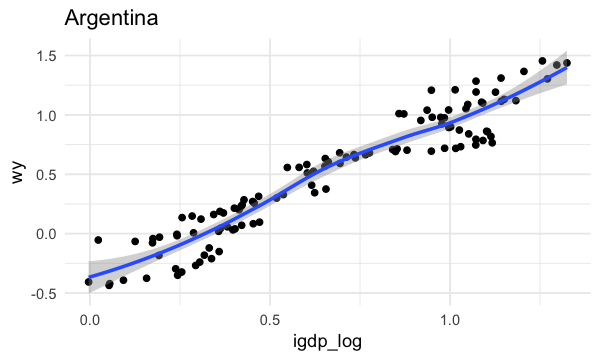

In [182]:
ggplot(test[ctry=='Argentina'], aes(igdp_log, wy)) + geom_point() + geom_smooth() + theme_minimal() + 
    labs(title='Argentina')

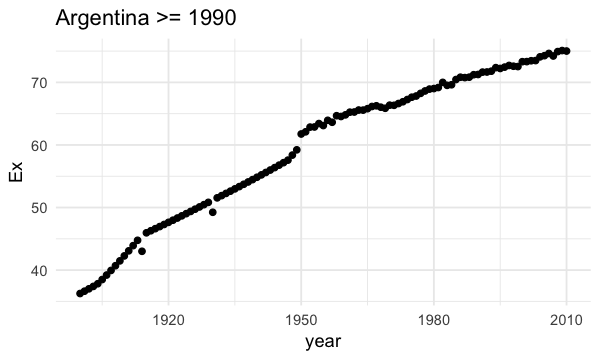

In [155]:
ggplot(test[ctry=='Argentina'], aes(year, Ex)) + geom_point()  + theme_minimal() + 
    labs(title='Argentina >= 1990')

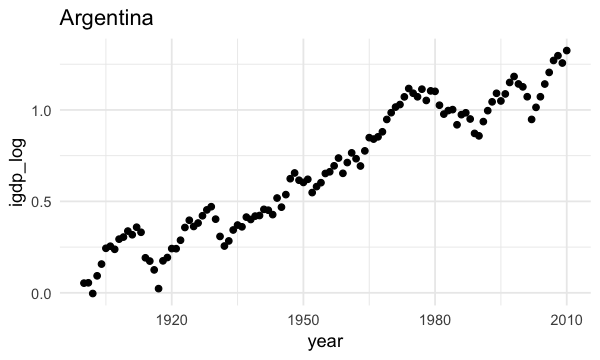

In [162]:
ggplot(test[ctry=='Argentina'], aes(year, igdp_log)) + geom_point()  + theme_minimal() + 
    labs(title='Argentina')